In [1]:
import os
import json
from langchain_openai import AzureChatOpenAI
import openai
import random
with open("../config.json") as config_file:
    config = json.load(config_file)

os.environ["AZURE_OPENAI_API_KEY"] = config["SECRET_KEY_OPENAI"]
os.environ["AZURE_OPENAI_ENDPOINT"] = config["BASE_URL"]
os.environ["AZURE_OPENAI_API_VERSION"] = "2023-05-15"
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["TAVILY_API_KEY"] = config["TAVILY_API_KEY"]

llm = AzureChatOpenAI(
        deployment_name="gpt-35-turbo", 
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
        model_name="gpt-35-turbo" 
    )



In [2]:
from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "abc123456"

In [3]:
stage_dict = {
    1:[2,3,4,5],
}

In [4]:
user_prompt_template = """System prompt: This is the structure of the whole story [graph, defined
by the author], currently it is in [stage 2], you should follow these
components:
event: 来自当前阶段用户定义的卡片的内容
character: 来自当前阶段用户定义的卡片的内容
the player's input: 来自当前阶段用户定义的卡片的内容
You should output the narrative...."""

In [5]:


def read_file_to_string(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content

In [6]:
file_path = 'stage1.txt'
file_content = read_file_to_string(file_path)
print(file_content)

# Undersea Adventures: Journey to the Earth's Core

In a distant future, humanity has crafted an extraordinary civilization beneath the waves. Advanced undersea cities, with their transparent domes and high-tech architecture, serve as vibrant habitats for people. These bustling metropolises feature underwater transportation systems and innovative agricultural methods, making life beneath the ocean both exciting and sustainable.

Deep-sea exploration has become more than a scientific pursuit; it’s a thrilling adventure that invites danger and discovery. Nations collaborate to uncover the secrets hidden in the ocean depths, pushing the boundaries of human knowledge and imagination.

Beneath this watery expanse lies the enchanting World of the Earth's Core. Here, lush forests and towering mountains thrive in a subterranean realm, illuminated by the glow of luminescent plants and creatures. Ancient civilizations have flourished for millennia, harnessing mysterious energies that shape their

In [7]:
def generate_prompt(curr_input, prompt_lib_file): 
  """
  Takes in the current input (e.g. comment that you want to classifiy) and 
  the path to a prompt file. The prompt file contains the raw str prompt that
  will be used, which contains the following substr: !<INPUT>! -- this 
  function replaces this substr with the actual curr_input to produce the 
  final promopt that will be sent to the GPT3 server. 
  ARGS:
    curr_input: the input we want to feed in (IF THERE ARE MORE THAN ONE
                INPUT, THIS CAN BE A LIST.)
    prompt_lib_file: the path to the promopt file. 
  RETURNS: 
    a str prompt that will be sent to OpenAI's GPT server.  
  """
  if type(curr_input) == type("string"): 
    curr_input = [curr_input]
  curr_input = [str(i) for i in curr_input]

  f = open(prompt_lib_file, "r")
  prompt = f.read()
  f.close()
  for count, i in enumerate(curr_input):   
    prompt = prompt.replace(f"!<INPUT {count}>!", i)
  if "<commentblockmarker>###</commentblockmarker>" in prompt: 
    prompt = prompt.split("<commentblockmarker>###</commentblockmarker>")[1]
  return prompt.strip()

prompt = generate_prompt(file_content,r'C:\Users\user\Desktop\UROP2100M\Stanford_AItown\reverie\backend_server\persona\prompt_template\v3_ChatGPT\get_entity.txt' )

In [8]:
import pprint as pprint
pprint.pprint(prompt)

('Given a text description of an event or a conversation, output CSV '
 "(comma-separated values) of all the people's name, the object people "
 'interact and the place the people are in about the description.\n'
 'Below is the format of the output. \n'
 'Description of an event or a conversation: [Provided]\n'
 "People's name, the object people interact and the place the people are in: "
 '[Fill in]\n'
 '===\n'
 'Description of an event or a conversation: # Undersea Adventures: Journey to '
 "the Earth's Core\n"
 '\n'
 'In a distant future, humanity has crafted an extraordinary civilization '
 'beneath the waves. Advanced undersea cities, with their transparent domes '
 'and high-tech architecture, serve as vibrant habitats for people. These '
 'bustling metropolises feature underwater transportation systems and '
 'innovative agricultural methods, making life beneath the ocean both exciting '
 'and sustainable.\n'
 '\n'
 'Deep-sea exploration has become more than a scientific pursuit

In [9]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain.chains import GraphCypherQAChain
from langchain_core.prompts.prompt import PromptTemplate
from langgraph.checkpoint.sqlite import SqliteSaver

graph = Neo4jGraph()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    custom_ouput: bool

class OutputbyUser(BaseModel):
    """
    Represents the output generated by a user during a paused step in the graph.

    The `OutputbyUser` class allows users to pause the graph and provide their input.
    It captures the user's request and stores it as the `request` attribute.

    Attributes:
        request (str): The request made by the user during the paused step.

    """
    request: str

class Graphretriever:
    def __init__(self, docs ,graph_docs, graph):
        self._graph_docs = graph_docs 
        self._docs = docs
        self._graph = graph

    @classmethod
    def from_docs(cls, docs,graph):
        docs = [Document(page_content=docs)]
        llm_transformer = LLMGraphTransformer(llm=llm,
                                              allowed_nodes=["Person", "Location", "Buildings", "Items",'Animal', 'Robots', 'Time', 'Year'],
    allowed_relationships=["HAVE_USED", "LOCATED_IN", "WORKED_AT", "SPOUSE", 'FRIEND', "ENEMY", "MENTOR", "LIKE", "LOVE", "DISLIKE", "HAVE_SEEN", 'HAVE_CREATE', "IS_BORNED",
                           'HAS_DIE', 'PET', "HAVE_BUILDING","INSIDE", "HAS_MADE", 'HAS', 'Has_FACILITY'],
    node_properties=["born_year", 'dead_year', 'married_year', 'time_start_work', "build_time", "first_appear_time", 'country', 
                     'function', 'creator', 'event_in'],)
        graph_docs = llm_transformer.convert_to_graph_documents(docs)
        graph.add_graph_documents(graph_docs)
        graph.refresh_schema()
        return cls(docs,graph_docs, graph)

    def query(self, query: str):
        CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
        Instructions:
        Use only the provided relationship types and properties in the schema.
        Do not use any other relationship types or properties that are not provided.
        Schema:
        {schema}
        Note: Do not include any explanations or apologies in your responses.
        Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
        Do not include any text except the generated Cypher statement.
        Examples: Here are a few examples of generated Cypher statements for particular questions:
        # How many people played in Top Gun?
        MATCH (m:Movie {{name:"Top Gun"}})<-[:ACTED_IN]-()
        RETURN count(*) AS numberOfActors

        The question is:
        {question}"""
        CYPHER_GENERATION_PROMPT = PromptTemplate(
            input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
        )
        chain = GraphCypherQAChain.from_llm(
            llm, graph=self._graph, verbose=True,cypher_prompt=CYPHER_GENERATION_PROMPT, validate_cypher=True,
                )
        return chain


retriever = Graphretriever.from_docs( '''Humanity has developed an advanced undersea civilization in the future. Undersea cities have become the primary habitats for humans, featuring high-tech architecture and facilities, including transparent domes, underwater transportation systems, underwater agriculture, and energy development facilities.''',graph)

@tool
def documentLookup(arg: str):
    """
    Perform a lookup in the graph of relationships with entities such as events, people, places, and objects.

    The function takes a query string as input and searches for relevant information in the graph.
    It uses the `retriever` object to execute the query and retrieve the desired results.

    """
    query = arg
    prompt_template = '''Find all the entities like person, buildings, locations, items , animal, robots, time ,year and another other thing that is interesting the graph. And find all the relationship between them, please
     note that the allowed relationship are "born_year", 'dead_year', 'married_year', 'time_start_work', "build_time", "first_appear_time", 'country', 
                     'function', 'creator', 'event_in'. 
                      Also assign suitable properties to the nodes like "born_year", 'dead_year', 'married_year', 'time_start_work', "build_time", "first_appear_time", 'country', 
                     'function', 'creator', 'event_in'. 
                       {query}'''
    prompt = prompt_template.format(query=query)
    chain = retriever.query(prompt)
    res = chain.run(query)
    # output = []
    # output.append(
    #     ToolMessage(
    #                 content=json.dumps(res),
    #                 name='documentLookup',
    #                 tool_call_id=tool_call["id"],
    # )
    return res

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tavily = TavilySearchResults(max_results=2)
tavily = [tavily]
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tavily +[ OutputbyUser, documentLookup])


In [10]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    custom_ouput = False
    print(f'{response.tool_calls}')
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == OutputbyUser.__name__
    ):
        custom_ouput = True
    return {"messages": [response], "custom_ouput": custom_ouput}

# def tool_router(state):
#     if state["custom_ouput"]:
#         return 'human'
#     messages = state["messages"]
#     last_message = messages[-1]
#     toolcalllist = []
#     for tool in  last_message.tool_calls:
#         toolcalllist.append(tool["name"])
#     if documentLookup in toolcalllist:
#         return "lookup"
#     return "__end__"
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if state["custom_ouput"]:
        return 'human'
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


In [11]:
graph_builder = StateGraph(State)
tool_node = BasicToolNode(tools=tavily + [documentLookup])
graph_builder.add_node("tools", tool_node)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge("__start__", "chatbot")


In [12]:
def create_response(response: str, ai_message: AIMessage):
    for tool_call in ai_message.tool_calls:
        if tool_call["name"] == OutputbyUser.__name__:
            return ToolMessage(
                content=response,
                tool_call_id=tool_call["id"],
            )

In [13]:
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [14]:
graph_builder.add_node("human", human_node)

In [15]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "human": "human", "__end__": "__end__"},
)

In [16]:
memory = SqliteSaver.from_conn_string(":memory:")

In [17]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
state_graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

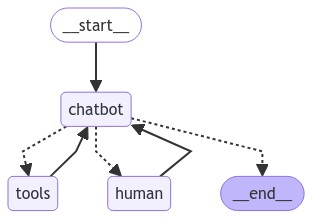

In [18]:
from IPython.display import Image, display

try:
    display(Image(state_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
# docs = '''Humanity has developed an advanced undersea civilization in the future. Undersea cities have become the primary habitats for humans, featuring high-tech architecture and facilities, including transparent domes, underwater transportation systems, underwater agriculture, and energy development facilities.'''
# docs = [Document(page_content=docs)]
# llm_transformer = LLMGraphTransformer(llm=llm)
# graph_docs = llm_transformer.convert_to_graph_documents(docs)
# print(f"Nodes:{graph_docs[0].nodes}")
# print(f"Relationships:{graph_docs[0].relationships}")

In [20]:
# graph.add_graph_documents(graph_docs)

In [21]:
user_input = "show all the node and relationships contained in the outward edges of the unersea cities node "
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = state_graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

show all the node and relationships contained in the outward edges of the unersea cities node 
[{'name': 'documentLookup', 'args': {'arg': 'outward edges of the undersea cities node'}, 'id': 'call_4w4govbvjG8p25AbBGE9YvRr', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  documentLookup (call_4w4govbvjG8p25AbBGE9YvRr)
 Call ID: call_4w4govbvjG8p25AbBGE9YvRr
  Args:
    arg: outward edges of the undersea cities node


> Entering new GraphCypherQAChain chain...


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Generated Cypher:
MATCH (:Buildings)-[:HAS_FACILITY]->(:Items)
RETURN count(*) AS numberOfFacilities
Full Context:
[{'numberOfFacilities': 2}]

> Finished chain.
================================= Tool Message =================================
Name: documentLookup

"I don't know the answer."
[]
================================== Ai Message ==================================

I couldn't find specific information about the outward edges of the undersea cities node. Would you like me to look up more general information about undersea cities for you?


In [22]:
snapshot = state_graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='show all the node and relationships contained in the outward edges of the unersea cities node ', id='2b5b9aa1-8f48-4512-846e-92acb38fe027'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4w4govbvjG8p25AbBGE9YvRr', 'function': {'arguments': '{"arg":"outward edges of the undersea cities node"}', 'name': 'documentLookup'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 263, 'total_tokens': 285}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': 'fp_811936bd4f', 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-03c84315-ee05-4d0e-b654-6e162bc8346f-0', tool_calls=[{'name': 'documentLookup', 'args': {'arg': 'outward edges of the undersea cities node'}, 'id': 'call_4w4govbvjG8p25AbBGE9YvRr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 263, 'output_tokens': 22, 'total_tokens': 285}), ToolMessage(content='"I don\'

In [23]:
snapshot.next

()

: 